In [1]:
import finesse
import numpy as np
import matplotlib.pyplot as plt
finesse.configure(plotting=True, progress_bars=True)

In [2]:
kat = finesse.Model()
kat.parse(
    """
    # Add a Laser named L0 with a power of 1 W.
    l L0 P=1

    # Space attaching L0 <-> m1 with length of 0 m (default).
    s s0 L0.p1 m1.p1

    # Input mirror of cavity.
    m m1 R=0.99 T=0.01

    # Intra-cavity space with length of 1 m.
    s CAV m1.p2 m2.p1 L=1

    # End mirror of cavity.
    m m2 R=0.991 T=0.009 phi=1

    # Power detectors on reflection, circulation and transmission.
    pd refl m1.p1.o
    pd circ m2.p1.i
    pd trns m2.p2.o

    # Scan over the detuning DOF of m1 from -180 deg to +180 deg with 400 points.
    #xaxis(m1.phi, lin, -180, 180, 400)
    modes(maxtem=2)
    """
)

In [2]:
katout = kat.deepcopy()
katout.m1.Rc = -10
katout.m2.Rc = 10
katout.parse("""

cav cavity m1.p2.o
""")
out = katout.run()
out["circ"], out[katout.circ], out[["circ", "refl"]], out.data, out.outputs

NameError: name 'kat' is not defined

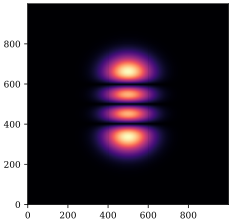

In [22]:
q = (3.7748891540346423j)
HG33 = finesse.gaussian.HGMode(q, n=3, m=0)
HG00 = finesse.gaussian.HGMode(q, n=0, m=0)

x = y = np.linspace(-0.005, 0.005, 1000)
step = x[1] - x[0]
# HG33data = HG33.unm(x, y).astype("float")
HG33data = HG33.unm(x, y)
HG00data = HG00.unm(x, y)

plt.imshow(np.abs(HG33data));

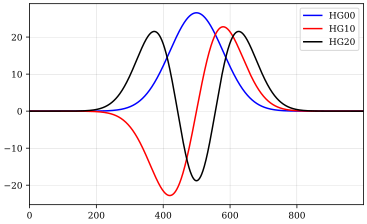

In [25]:
HG20 = finesse.gaussian.HGMode(q, n=2, m=0)
HG10 = finesse.gaussian.HGMode(q, n=1, m=0)
HG30 = finesse.gaussian.HGMode(q, n=3, m=0)
HG00 = finesse.gaussian.HGMode(q, n=0, m=0)



plt.plot(np.real(HG00.un(x)), label="HG00")
plt.plot(np.real(HG10.un(x)), label="HG10")
plt.plot(np.real(HG20.un(x)), label="HG20")
# plt.plot(np.real(HG30.un(x)), label="HG30")
plt.legend();

In [13]:
1 - np.sum(HG33data*np.conj(HG33data))*step**2

(0.8181302163935084+0j)

In [14]:
1 - np.sum(HG00data*np.conj(HG00data))*step**2

(0.023670045052491595+0j)

## How to remove an element

In [6]:
kat_remove = kat.deepcopy()
kat_remove.remove(kat_remove.s0)
kat_remove.remove(kat_remove.CAV)
kat_remove.remove(kat_remove.m1)
print(kat_remove.unparse())


    # Add a Laser named L0 with a power of 1 W.
    l L0 P=1

    # Space attaching L0 <-> m1 with length of 0 m (default).
    

    # Input mirror of cavity.
    

    # Intra-cavity space with length of 1 m.
    

    # End mirror of cavity.
    m m2 R=0.991 T=0.009 L=0.0 phi=1

    # Power detectors on reflection, circulation and transmission.
    pd refl m1.p1.o
    pd circ m2.p1.i
    pd trns m2.p2.o

    # Scan over the detuning DOF of m1 from -180 deg to +180 deg with 400 points.
    #xaxis(m1.phi, lin, -180, 180, 400)
    
# Items below could not be matched to original script, or were not present when the model was originally parsed.






## minimize or maximize that can be used to find the tuning

In [7]:
model = finesse.Model()
model.parse('''
l l1 P=1
pd P l1.p1.o
minimize(P, l1.P, fatol=1e-9)
''')
sol = model.run()
print(sol.result)

 final_simplex: (array([[1.49011523e-09],
       [2.23517329e-09]]), array([1.49011523e-09, 2.23517329e-09]))
           fun: 1.4901152312063472e-09
       message: 'Optimization terminated successfully.'
          nfev: 120
           nit: 60
        status: 0
       success: True
             x: array([1.49011523e-09])


In [8]:
kat_tuning = kat.deepcopy()

# there are two ways
sol_tuning, state = kat_tuning.run("noxaxis(pre_step=maximize(circ, m2.phi, bounds=[-10, 10]))", 
                                   return_state=True)
print(sol_tuning["pre_step", "maximize"].x, sol_tuning['circ'], state.model.m2.phi)

# there is another way
sol_tuning, state = kat_tuning.run("maximize(circ, m2.phi, bounds=[-10, 10])", return_state=True)

print(sol_tuning.x, kat_tuning.run()['circ'], state.model.m2.phi)

[-8.8817842e-16] 110.80036618442 1.0 degrees
[-8.8817842e-16] 110.80036618442 9.765624999911191e-05 degrees


In [9]:
kat_tuning.spaces.s0.L, kat_tuning.m2.phi

(<s0.L=0.0 @ 0x161af6640>, <m2.phi=9.765624999911191e-05 @ 0x161ac5e80>)

## Cavity command needs to be careful not to include the AR substrate using via

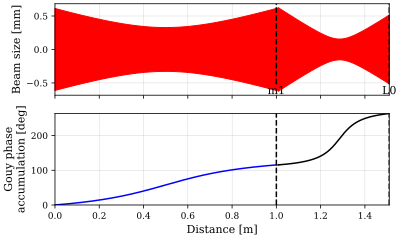

In [12]:
# kat2 = kat.deepcopy()
# kat2.remove(kat2.s0)

kat2 = finesse.Model()
kat2.parse(
    "\n".join(
        [l for l in kat.unparse().splitlines() if "s0" not in l]
    )
)

kat2.m1.Rc = -0.7
kat2.m2.Rc = 0.7

# Add a silicon lens with an AR surface to the input coupler.
kat2.parse(
    """
    space s0 L0.p1 m1_AR.p1 L=0.5
    mirror m1_AR R=100e-6 L=10e-6 Rc=-0.3
    space s_M1_sub portA=m1_AR.p2 portB=m1.p1 L=10e-3 nr=3.5
    
    cavity cavity1 source=m2.p1.o via=m1.p2.i priority=1
    #cavity cavity1 source=m2.p1.o via=m1_AR.p2.i priority=1
    
    """
)

# Plot beam trace, starting from the cavity eigenmode.
tsy = finesse.tracing.tools.propagate_beam(
    to_node=kat2.L0.p1.i, from_node=kat2.m2.p1.o, direction="y"
)
tsy.plot();

## The optimal gain is -1/slope or 1/slope, depending on the stuff you are locking

In [3]:
model = finesse.Model()
model.parse(
    """
    laser i1 P=1 f=0
    space s1 portA=i1.p1 portB=eo1.p1
    modulator eo1 15M 0.3 order=3
    space s2 portA=eo1.p2 portB=m1.p1
    mirror m1 R=0.9 T=0.1
    space s3 portA=m1.p2 portB=m2.p1 L=1
    mirror m2 R=0.9 T=0.1 phi=0.1

    power_detector_dc refl node=m1.p1.o
    power_detector_dc trans node=m2.p2.o
    """
)

# model.parse(f"pd1 pdh9 node=m1.p1.o f=&eo1.f phase=9")
# model.parse("xaxis(m2.phi, lin, -100, 100, 400)")
# out = model.run()
# out.plot();
# print(-((out["pdh9"][200]-out["pdh9"][199])/(200/400))**(-1))

model.parse("""
power_detector_demod_1 pdh node=m1.p1.o f=&eo1.f phase=9
lock lock_length pdh m1.phi -10.847657511583396 1e-9
noxaxis(pre_step=run_locks(display_progress=true,))
#xaxis(m2.phi, lin, 0, 100, 400, pre_step=run_locks(display_progress=true,))
""")
model.run();

Error Signal Residuals at Each Iteration (W):
                         lock_length  
Iteration Number   0     -9.45e-03   
Iteration Number   1      2.43e-04   
Iteration Number   2     -6.48e-06   
Iteration Number   3      1.73e-07   
Iteration Number   4     -4.63e-09   
Iteration Number   5      1.24e-10   


In [15]:
from finesse.plotting import plot_field
from finesse.knm import Map
from finesse.utilities.maps import circular_aperture

In [16]:
model = finesse.Model()
model.parse(
    """
    l l1
    mod mod1 f=9.1M midx=0.1
    m m1 R=0.984 T=0.014 Rc=-1940
    m m2 R=1 T=0 Rc=2245
    link(l1, mod1, m1, 3994, m2)
    cav cavity m2.p1.o
    modes(maxtem=20)

    fd E_arm m2.p1.i l1.f  # Field detector
    """
)

x = y = np.linspace(-0.17, 0.17, 100)
ligo_ap = circular_aperture(x, y, 0.17)
ligo_ap[:, abs(y) >= 0.163] = 0
model.m1.surface_map = Map(x, y, amplitude=ligo_ap)
model.m2.surface_map = Map(x, y, amplitude=ligo_ap)

sol_aperture = model.run("eigenmodes(cavity, 0, name='c0')")
print(abs(sol_aperture.eigvalues))
print(np.angle(sol_aperture.eigvalues))

[9.91967373e-01 9.41355411e-01 9.55881543e-01 9.68412200e-01
 9.83800605e-01 9.91871901e-01 9.91922891e-01 9.55005492e-01
 8.53159374e-01 9.87136995e-01 9.88804929e-01 9.90721549e-01
 8.89903522e-01 9.91960979e-01 9.91963531e-01 8.22998851e-01
 7.85284036e-01 7.11098493e-01 9.73970471e-01 9.74539940e-01
 9.41539325e-01 9.42318917e-01 8.61158724e-01 8.97348149e-01
 9.12721558e-01 9.09522539e-01 9.83765516e-01 9.55204929e-01
 9.14000701e-01 9.16540005e-01 9.74766522e-01 9.79298947e-01
 9.83058069e-01 9.91931774e-01 9.70137776e-01 9.58094634e-01
 9.82432690e-01 9.88531886e-01 9.88542674e-01 9.91051914e-01
 9.91421057e-01 9.91723938e-01 9.91689341e-01 8.88696718e-01
 7.92144987e-01 7.96828404e-01 9.89141071e-01 9.90864262e-01
 5.23284393e-01 8.30034348e-01 7.91288354e-01 6.78006464e-01
 8.52888407e-01 6.74230382e-01 6.01305647e-01 6.87287148e-01
 6.93123355e-01 6.01749304e-01 7.69541548e-01 7.71818553e-01
 6.79013066e-01 5.22234338e-01 6.24867295e-01 6.19618232e-01
 5.97593088e-01 4.381045

In [17]:
sol_aperture.eigvectors

array([[ 9.99999817e-01+0.00000000e+00j, -4.38330557e-05+7.46215738e-05j,
        -2.57315077e-05+4.74067845e-05j, ...,
        -1.24179264e-06+7.30583446e-07j, -2.41783033e-13-3.62020253e-13j,
        -3.93955969e-13+1.38379421e-13j],
       [-2.48360845e-17+4.14056646e-17j,  1.61252969e-17-6.37160103e-17j,
        -8.02018860e-17+4.10276236e-17j, ...,
        -6.79867193e-13-1.18622958e-12j, -2.69488460e-13+4.08989029e-13j,
         4.74387974e-13-4.38354801e-13j],
       [-1.99149901e-17+1.35855020e-17j,  3.92719313e-19-6.84563820e-17j,
        -1.31902384e-16-1.59711996e-17j, ...,
        -4.90266949e-14-1.95549082e-14j, -2.94112319e-14+1.27743094e-14j,
        -3.48203876e-14+2.71500792e-14j],
       ...,
       [-1.65953636e-05-5.52278210e-06j, -6.77308600e-04+3.57500802e-04j,
        -9.05544250e-03+8.18655222e-04j, ...,
        -1.77727381e-03+1.56908467e-02j,  8.90223280e-09+7.49499321e-10j,
        -2.98788091e-09+8.96120000e-09j],
       [-1.14296254e-24+2.92524006e-26j, -1.

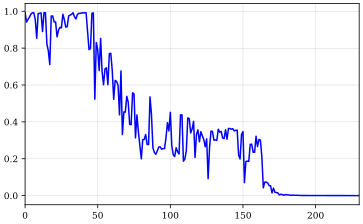

In [18]:
plt.plot(abs(sol_aperture.eigvalues));

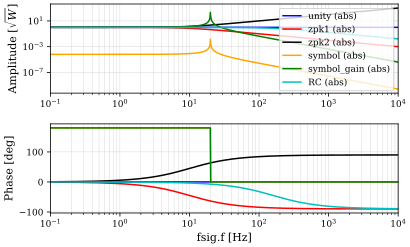

In [19]:
model = finesse.Model()
model.parse("""
# Finesse always expects some optics to be present
# so we make a laser incident on some photodiode
l l1 P=1
readout_dc PD l1.p1.o
# Amplitude modulate a laser
sgen sig l1.amp

zpk ZPK_unity [] []
link(PD.DC, ZPK_unity)
ad unity ZPK_unity.p2.o f=&fsig

zpk ZPK_1 [] [-10*2*pi]
link(PD.DC, ZPK_1)
ad zpk1 ZPK_1.p2.o f=&fsig

zpk ZPK_2 [-10*2*pi] []
link(PD.DC, ZPK_2)
ad zpk2 ZPK_2.p2.o f=&fsig

# Using symbolics
variable a 20*2*pi
zpk ZPK_symbol [] [-1j*&a, 1j*&a] -1
link(PD.DC, ZPK_symbol)
ad symbol ZPK_symbol.p2.o f=&fsig

# Using gain parameter instead of k keeps the unity response at DC but
# just flips the sign
zpk ZPK_symbol2 [] [-1j*&a, 1j*&a] gain=-1
link(PD.DC, ZPK_symbol2)
ad symbol_gain ZPK_symbol2.p2.o f=&fsig

# Symbolics for an RC low pass filter
variable R 100
variable C 10u
zpk ZPK_RC [] [-1/(&R*&C)]
link(PD.DC, ZPK_RC)
ad RC ZPK_RC.p2.o f=&fsig

fsig(1)
xaxis(fsig, log, 0.1, 10k, 1000)
""")

sol = model.run()
sol.plot(log=True);

In [9]:
model = finesse.Model()
model.parse(
    """
    l l1
    mod mod1 f=9.1M midx=0.1
    m m1 R=0.984 T=0.016 Rc=-2245
    m m2 R=1 T=0 Rc=2245
    link(l1, mod1, m1, 3994, m2)
    cav cavity m2.p1.o
    modes(maxtem=2)

    fd E_arm m2.p1.i l1.f  # Field detector
    """
)

sol = model.run(
    """
    series(
        eigenmodes(cavity, -mod1.f, name="l9"),
        eigenmodes(cavity, 0,       name="c0"),
        eigenmodes(cavity, mod1.f,  name="u9"),
        xaxis(m2.phi, lin, -10, 190, 500, name="scan")
    )
    """
)

print(abs(sol["c0"].eigvalues))
print(np.angle(sol["c0"].eigvalues))

[0.99196774 0.99196774 0.99196774 0.99196774 0.99196774 0.99196774]
[ 0.         -1.35524783 -1.35524783 -2.71049566 -2.71049566 -2.71049566]
